In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from ema_workbench import load_results
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, CategoricalParameter, IntegerParameter,
                           perform_experiments, SequentialEvaluator, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.util import ema_logging, utilities
import time
from problem_formulation import get_model_for_problem_formulation
#from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE, SIG_DFL)

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## MORDM

MORDM consists of four main steps:
1. Problem formulation 
2. Searching for candidate solutions
3. Generating an ensemble of scenarios to explore the effect of uncertainties
4. Using scenario discovery to detect the vulnerabilities of candidate solutions and to improve them


### 1. Problem formulation

For Dike Ring 1, the following objectives, all to be minimized, are of interest:\
•	A.1 Expected Annual Damage\
•	A.1 Dike Investment Costs\
•	A.1 Expected Annual Number of Deaths\
•	Total Expected Annual Number of Deaths

## 2. Searching for candidate solutions

### Constraints

For each outcome of interest we have set a specific constraint that the candidate solutions must follow. We will determine most of them by looking at the random policies that were generated with open exploration.

In [3]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate[metric] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate[location + '_' + metric] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric for location in locations]
            df_aggregate['Total ' + metric] = df_aggregate[columns_locations].sum(axis=1)
    
 
    return df_aggregate

In [4]:
outcomes_of_interest = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]

In [5]:
#Load in the results
results_rp=utilities.load_results('results/policies_fully_disaggregated.tar.gz')
experiments_rp, outcomes_rp = results_rp
df_outcomes_rp_unaggregated = pd.DataFrame(outcomes_rp)

df_rp = aggregate_df(df_outcomes_rp_unaggregated)
df_rp = df_rp[outcomes_of_interest]
df_rp

[MainProcess/INFO] results loaded successfully from C:\Users\User\Documents\GitHub\EPA_Group7_MBDM\final assignment\results\policies_fully_disaggregated.tar.gz


,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,0.000000e+00,2.006358e+08,0.000000,0.006540,6.640217e+07
1,0.000000e+00,2.006358e+08,0.000000,0.020768,1.431763e+08
2,0.000000e+00,2.006358e+08,0.000000,0.005515,5.264942e+07
3,0.000000e+00,2.006358e+08,0.000000,0.003705,2.574227e+07
4,0.000000e+00,2.006358e+08,0.000000,0.056785,5.248435e+08
...,...,...,...,...,...
39995,0.000000e+00,1.351227e+08,0.000000,0.000276,1.287416e+06
39996,0.000000e+00,1.351227e+08,0.000000,0.000044,3.102785e+05
39997,0.000000e+00,1.351227e+08,0.000000,0.000039,4.155308e+05
39998,6.111999e+08,1.351227e+08,0.087021,0.087021,6.111999e+08


In [6]:
# Constraint1: We don't want number of deaths to exceed 10%. So, max_total_deaths is defined as 0.01% * 3 time steps * 5 locations.
# Constraint2: For A1 speficially, expected annual damage shouldn't exceed the median damage.
# Constraint3: For A1 specifically, number of deaths should not exceed median. 
# We argue that the other outcomes, tied to costs are important to optimize over, but are not our main objective, therefore are no hard constraints
max_total_deaths = 0.0001 * 3 * 5
max_deaths_a1 = df_rp.iloc[:,2].median()
max_damage_a1 = df_rp.iloc[:,0].median()

In [7]:
constraints = [Constraint("Max Total Number of deaths", outcome_names='Expected Number of Deaths', function=lambda x:max(0, x-max_total_deaths)),
               Constraint("Max A.1 Expected Annual Damage", outcome_names="A.1_Expected Annual Damage", function=lambda x:max(0, x-max_damage_a1)),
               Constraint("Max A.1 Expected Number of Deaths", outcome_names="A.1_Expected Number of Deaths", function=lambda x:max(0, x-max_deaths_a1))
              ]

In [8]:
outcome_ranges = pd.read_csv("results/outcome_ranges.csv")
outcome_ranges.set_index("Unnamed: 0",inplace=True)
outcome_ranges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, A.1_Expected Annual Damage to Total Expected Annual Damage
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Max_values  5 non-null      float64
 1   Min_values  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes


In [9]:
#Define the reference scenario
dike_model, planning_steps = get_model_for_problem_formulation(0)

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

In [10]:
df_rp.columns

Index(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'Total Expected Number of Deaths',
       'Total Expected Annual Damage'],
      dtype='object')

In [11]:
df_rp = df_rp[['Total Expected Annual Damage', 'Total Expected Number of Deaths', 'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths']]
df_rp

,Total Expected Annual Damage,Total Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths
0,6.640217e+07,0.006540,0.000000e+00,2.006358e+08,0.000000
1,1.431763e+08,0.020768,0.000000e+00,2.006358e+08,0.000000
2,5.264942e+07,0.005515,0.000000e+00,2.006358e+08,0.000000
3,2.574227e+07,0.003705,0.000000e+00,2.006358e+08,0.000000
4,5.248435e+08,0.056785,0.000000e+00,2.006358e+08,0.000000
...,...,...,...,...,...
39995,1.287416e+06,0.000276,0.000000e+00,1.351227e+08,0.000000
39996,3.102785e+05,0.000044,0.000000e+00,1.351227e+08,0.000000
39997,4.155308e+05,0.000039,0.000000e+00,1.351227e+08,0.000000
39998,6.111999e+08,0.087021,6.111999e+08,1.351227e+08,0.087021


In [12]:
#Define the values for epsilon
list_epsilons=[]
for column in df_rp.columns:
    new_df = df_rp[df_rp[column] >0]
    epsilon=min(new_df[column])
    list_epsilons.append(epsilon)

In [13]:
df_rp.columns

Index(['Total Expected Annual Damage', 'Total Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths'],
      dtype='object')

In [14]:
outcome_ranges

,Max_values,Min_values
Unnamed: 0,,
A.1_Expected Annual Damage,3.694513e+09,0.0
A.1_Dike Investment Costs,3.753980e+08,0.0
A.1_Expected Number of Deaths,1.834596e+00,0.0
Total Expected Number of Deaths,5.276779e+00,0.0
Total Expected Annual Damage,5.736794e+09,0.0


In [15]:
from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress
max_vals=[]
max_vals=[outcome_ranges.iloc[4,0],outcome_ranges.iloc[3,0],outcome_ranges.iloc[0,0],outcome_ranges.iloc[1,0],outcome_ranges.iloc[2,0]]
max_vals

[5736794173.005579,
 5.276778645570779,
 3694513006.6833086,
 375398028.08627385,
 1.8345956996319948]

In [ ]:
from problem_formulation_modified import get_model_for_problem_formulation_modified
dike_model,planning_steps = get_model_for_problem_formulation_modified(outcome_ranges)






  0%|                                                   | 0/10 [00:00<?, ?it/s]




100it [04:14,  2.54s/it]                                                       
[MainProcess/INFO] optimization completed, found 3 solutions


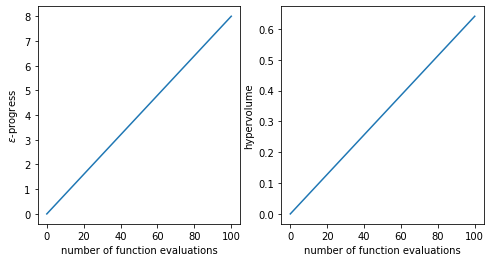

In [21]:
convergence_metrics = [
    HyperVolume(minimum=[0, 0, 0, 0, 0], maximum=max_vals),
    EpsilonProgress(),
]

model=dike_model

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=10,
        searchover="levers",
        reference=ref_scenario,
        convergence=convergence_metrics,
        epsilons= list_epsilons
        * len(model.outcomes),
        constraints=constraints
    )

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress")
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel("hypervolume")

ax1.set_xlabel("number of function evaluations")
ax2.set_xlabel("number of function evaluations")
plt.show()

In [ ]:
results.to_csv("results/optimization_test_pols.csv")

In [ ]:
from ema_workbench.analysis import parcoords
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, list(df_rp.columns)] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()